In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from datetime import timedelta
from datetime import datetime as dt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Load data

### Errors encountered when loading in data:

- **ParserError**: Error tokenizing data. C error: Expected 13 fields in line 30, saw 14

 Reason: <br>
 - The were erroneous values such as 'Moccasins & Boat Shoes' in the `order_created_at` column, and as a result shifted the data for the `order_created_at` and `order_status` columns to the right by 1 column, resulting in 14 columns.

 - This 14th column had a blank header, which resulted in ParserError.

 Solution: <br>
 - Specify a list of 14 column names before reading in csv; extra column named as 'error'.<br><br>

- **UnicodeDecodeError**: 'utf-8' codec can't decode byte 0xc9 in position 82: invalid continuation byte

 Solution:
  - When reading in csv, include parameter `encoding='latin-1'`

In [3]:
col_names = ['zuid','gender','birthday','cohort','order_nr','environment','voucher_code',
             'order_value','category','sub_category','order_created_at','order_status', 'error']

df = pd.read_csv('sales.csv', names=col_names, skipinitialspace=True, encoding='latin-1', low_memory=False)

In [4]:
df.head()

,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_created_at,order_status,error
0,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_created_at,order_status,NaN
1,2.13795E+14,male,(null),2016-07,205926117,mobileTheme,NaN,27.1,apparel,Shirts,2/8/16 0:52,net,NaN
2,2.13795E+14,male,(null),2016-07,207816617,mobileTheme,NaN,23.03,apparel,T-Shirts,22/7/16 13:06,net,NaN
3,2.13795E+14,male,(null),2016-07,205926117,mobileTheme,NaN,13.93,apparel,T-Shirts,2/8/16 0:52,net,NaN
4,2.13795E+14,male,(null),2016-07,508943717,NaN,NaN,14.02,apparel,Shorts,30/7/16 11:07,net,NaN


In [5]:
# Drop first row containing original headers from csv file
df.drop(df.index[0], inplace=True)
df.head(10)

,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_created_at,order_status,error
1,2.13795E+14,male,(null),2016-07,205926117,mobileTheme,NaN,27.1,apparel,Shirts,2/8/16 0:52,net,NaN
2,2.13795E+14,male,(null),2016-07,207816617,mobileTheme,NaN,23.03,apparel,T-Shirts,22/7/16 13:06,net,NaN
3,2.13795E+14,male,(null),2016-07,205926117,mobileTheme,NaN,13.93,apparel,T-Shirts,2/8/16 0:52,net,NaN
4,2.13795E+14,male,(null),2016-07,508943717,NaN,NaN,14.02,apparel,Shorts,30/7/16 11:07,net,NaN
5,2.13795E+14,male,(null),2016-07,205926117,mobileTheme,NaN,13.93,apparel,T-Shirts,2/8/16 0:52,net,NaN
6,2.13795E+14,male,(null),2016-07,207816617,mobileTheme,NaN,14.02,apparel,Shorts,22/7/16 13:06,returned,NaN
7,2.13795E+14,male,(null),2016-07,205926117,mobileTheme,NaN,13.93,apparel,T-Shirts,2/8/16 0:52,net,NaN
8,2.13795E+14,male,(null),2016-07,207816617,mobileTheme,NaN,14.02,apparel,T-Shirts,22/7/16 13:06,net,NaN
9,2.14675E+14,male,22/9/97,2016-11,203527495,iosApp,NaN,41.96,footwear,Heels,15/11/16 23:38,net,NaN
10,2.1471E+14,female,6/4/83,2016-08,207723237,desktop,NaN,28.01,footwear,Boots,12/8/16 20:19,net,NaN


# Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929476 entries, 1 to 929476
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   zuid              929476 non-null  object
 1   gender            927614 non-null  object
 2   birthday          929476 non-null  object
 3   cohort            929476 non-null  object
 4   order_nr          929476 non-null  object
 5   environment       910165 non-null  object
 6   voucher_code      371045 non-null  object
 7   order_value       929476 non-null  object
 8   category          929476 non-null  object
 9   sub_category      929344 non-null  object
 10  order_created_at  929476 non-null  object
 11  order_status      929476 non-null  object
 12  error             9234 non-null    object
dtypes: object(13)
memory usage: 99.3+ MB


Concerns with datatypes:

- `order_value` should be `float64`
- `order_created_at` should be `datetime64`
- `birthday` should be `datetime64`

### Fix 'order_created_at' column

In [7]:
# Find all erroneous text values in the 'order_created_at' column and replace with 
# the correct dates in the 'order_status' column
df['order_created_at'] = np.where(df['order_created_at'].str.contains('[A-Za-z]'), 
                                  df['order_status'], df['order_created_at'])

# Shift the order_status values in the temporary 'error' column back to the order_status column
df['order_status'] = np.where(df['order_created_at'].str.contains('[A-Za-z]'), 
                              df['error'], df['order_status'])

In [108]:
# Check the dataset
df.head()

,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_created_at,order_status,order_time,order_hour,order_year_mth,order_month,order_day,age
1,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,27.10,apparel,Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
2,2.13795E+14,male,NaT,2016-07,207816617,mobile,NaN,23.03,apparel,T-Shirts,2016-07-22 13:06:00,net,13:06:00,13,22/7/16,7,4,NaN
3,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
4,2.13795E+14,male,NaT,2016-07,508943717,NaN,NaN,14.02,apparel,Shorts,2016-07-30 11:07:00,net,11:07:00,11,30/7/16,7,5,NaN
5,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN


In [9]:
# Now, we can drop the 'error' column
df.drop('error', axis=1, inplace=True)

### Standardise NA values to np.nan

In [10]:
# Replace irregular null values with np.nan 
faulty_values = ['(null)', 'nan']
df.replace(faulty_values, np.nan, inplace=True)

In [107]:
df.head()

,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_created_at,order_status,order_time,order_hour,order_year_mth,order_month,order_day,age
1,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,27.10,apparel,Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
2,2.13795E+14,male,NaT,2016-07,207816617,mobile,NaN,23.03,apparel,T-Shirts,2016-07-22 13:06:00,net,13:06:00,13,22/7/16,7,4,NaN
3,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
4,2.13795E+14,male,NaT,2016-07,508943717,NaN,NaN,14.02,apparel,Shorts,2016-07-30 11:07:00,net,11:07:00,11,30/7/16,7,5,NaN
5,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN


In [12]:
# Check number of na values in each column:
df.isna().sum()

zuid                     0
gender                1862
birthday            345425
cohort                   0
order_nr                 0
environment          19311
voucher_code        558431
order_value              0
category             22515
sub_category           132
order_created_at         0
order_status             0
dtype: int64

### Convert datatypes

In [13]:
# Convert datatypes for columns, and assign it back to the column since the astype() function only returns a copy.
df['order_value'] = df['order_value'].astype(float)
df['birthday'] = pd.to_datetime(df['birthday'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929476 entries, 1 to 929476
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zuid              929476 non-null  object        
 1   gender            927614 non-null  object        
 2   birthday          584051 non-null  datetime64[ns]
 3   cohort            929476 non-null  object        
 4   order_nr          929476 non-null  object        
 5   environment       910165 non-null  object        
 6   voucher_code      371045 non-null  object        
 7   order_value       929476 non-null  float64       
 8   category          906961 non-null  object        
 9   sub_category      929344 non-null  object        
 10  order_created_at  929476 non-null  object        
 11  order_status      929476 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 92.2+ MB


### Create new date/time columns

In [15]:
# Extract out order time
df['order_time'] = pd.to_datetime(df['order_created_at']).dt.time

In [16]:
# Extract hour
df['order_hour'] = pd.to_datetime(df['order_time'], format='%H:%M:%S').dt.hour

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929476 entries, 1 to 929476
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zuid              929476 non-null  object        
 1   gender            927614 non-null  object        
 2   birthday          584051 non-null  datetime64[ns]
 3   cohort            929476 non-null  object        
 4   order_nr          929476 non-null  object        
 5   environment       910165 non-null  object        
 6   voucher_code      371045 non-null  object        
 7   order_value       929476 non-null  float64       
 8   category          906961 non-null  object        
 9   sub_category      929344 non-null  object        
 10  order_created_at  929476 non-null  object        
 11  order_status      929476 non-null  object        
 12  order_time        929476 non-null  object        
 13  order_hour        929476 non-null  int64         
dtypes: d

In [18]:
# Extract out YYYY-MM of order
df['order_year_mth'] = df['order_created_at'].str[0:7]

In [19]:
# Convert to datetime dtype
df['order_created_at'] = pd.to_datetime(df['order_created_at'])

In [20]:
# Extract out the month 
# code is different from the others above because we have already converted order_created_at to datetime format
df['order_month'] = df.order_created_at.dt.month

In [21]:
# Extract day of week
df['order_day'] = df['order_created_at'].dt.dayofweek  # Monday=0, Sunday=6

In [109]:
df.head()

,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_created_at,order_status,order_time,order_hour,order_year_mth,order_month,order_day,age
1,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,27.10,apparel,Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
2,2.13795E+14,male,NaT,2016-07,207816617,mobile,NaN,23.03,apparel,T-Shirts,2016-07-22 13:06:00,net,13:06:00,13,22/7/16,7,4,NaN
3,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
4,2.13795E+14,male,NaT,2016-07,508943717,NaN,NaN,14.02,apparel,Shorts,2016-07-30 11:07:00,net,11:07:00,11,30/7/16,7,5,NaN
5,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929476 entries, 1 to 929476
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zuid              929476 non-null  object        
 1   gender            927614 non-null  object        
 2   birthday          584051 non-null  datetime64[ns]
 3   cohort            929476 non-null  object        
 4   order_nr          929476 non-null  object        
 5   environment       910165 non-null  object        
 6   voucher_code      371045 non-null  object        
 7   order_value       929476 non-null  float64       
 8   category          906961 non-null  object        
 9   sub_category      929344 non-null  object        
 10  order_created_at  929476 non-null  datetime64[ns]
 11  order_status      929476 non-null  object        
 12  order_time        929476 non-null  object        
 13  order_hour        929476 non-null  int64         
 14  orde

### Update values in 'environment' column

In [24]:
df.environment.unique()

array(['mobileTheme', nan, 'iosApp', 'desktop', 'tabletTheme',
       'androidApp'], dtype=object)

For easier analysis, I will combine 'mobileTheme', 'iosApp', and 'androidApp' together under 'mobile'.

In [25]:
# Lump 'mobileTheme', 'iosApp', and 'androidApp' together under 'mobile'
df.replace({'environment': {'mobileTheme':'mobile', 'iosApp':'mobile', 'androidApp':'mobile'}}, inplace=True)

# Rename 'tabletTheme' to 'tablet'
df.environment.replace('tabletTheme', 'tablet', inplace=True)

df.environment.unique()

array(['mobile', nan, 'desktop', 'tablet'], dtype=object)

# Exploratory Data Analysis

In [26]:
df.head()

,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_created_at,order_status,order_time,order_hour,order_year_mth,order_month,order_day
1,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,27.10,apparel,Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0
2,2.13795E+14,male,NaT,2016-07,207816617,mobile,NaN,23.03,apparel,T-Shirts,2016-07-22 13:06:00,net,13:06:00,13,22/7/16,7,4
3,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0
4,2.13795E+14,male,NaT,2016-07,508943717,NaN,NaN,14.02,apparel,Shorts,2016-07-30 11:07:00,net,11:07:00,11,30/7/16,7,5
5,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0


In [27]:
print("Number of customers:", df['zuid'].nunique())
print("Number of successful orders: ", df['order_nr'].nunique())

Number of customers: 1192
Number of successful orders:  326618


### Percentage of successful orders

In [28]:
df_order_stat = df.groupby('order_status', as_index=False).agg({'order_nr': pd.Series.nunique})

In [29]:
df_order_stat

,order_status,order_nr
0,1/1/16 22:22,1
1,1/1/16 22:23,1
2,1/1/16 22:24,1
3,1/1/16 22:25,1
4,1/1/16 22:26,1
...,...,...
7883,canceled,12557
7884,invalid,25468
7885,net,267262
7886,rejected,3834


There seems to be many rows with erroneous date values in the order_status column. We will ignore those rows and focus on the ones with a proper order status. 

#### drop rows with dates

In [30]:
# Filter out rows with date values
df_order_stat = df_order_stat[df_order_stat.order_status.str[0:2] != '20']
df_order_stat

,order_status,order_nr
0,1/1/16 22:22,1
1,1/1/16 22:23,1
2,1/1/16 22:24,1
3,1/1/16 22:25,1
4,1/1/16 22:26,1
...,...,...
7883,canceled,12557
7884,invalid,25468
7885,net,267262
7886,rejected,3834


In [31]:
# Total orders made, including unsuccessful ones
df_order_stat.sum()

order_status    1/1/16 22:221/1/16 22:231/1/16 22:241/1/16 22:...
order_nr                                                   390385
dtype: object

In [32]:
# percentage of successful orders
267262/382574

0.6985890311416876

### Keep only the successful orders for further analysis

In [33]:
df = df[df.order_status == 'net']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646680 entries, 1 to 929476
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zuid              646680 non-null  object        
 1   gender            645371 non-null  object        
 2   birthday          397118 non-null  datetime64[ns]
 3   cohort            646680 non-null  object        
 4   order_nr          646680 non-null  object        
 5   environment       631877 non-null  object        
 6   voucher_code      238108 non-null  object        
 7   order_value       646680 non-null  float64       
 8   category          628265 non-null  object        
 9   sub_category      646574 non-null  object        
 10  order_created_at  646680 non-null  datetime64[ns]
 11  order_status      646680 non-null  object        
 12  order_time        646680 non-null  object        
 13  order_hour        646680 non-null  int64         
 14  orde

In [34]:
# check 
df.order_status.unique()

array(['net'], dtype=object)

In [35]:
df.describe()

,order_value,order_hour,order_month,order_day
count,646680.000000,646680.000000,646680.000000,646680.000000
mean,28.755141,14.470434,6.396055,2.950815
std,28.066380,6.833077,3.500032,2.035006
min,-24.730000,0.000000,1.000000,0.000000
25%,13.930000,11.000000,3.000000,1.000000
50%,21.660000,15.000000,6.000000,3.000000
75%,32.620000,21.000000,10.000000,5.000000
max,1316.360000,23.000000,12.000000,6.000000


### Average age of Zalora's customers?

In [37]:
# we use max order date + 1 as "today's date" to simulate a real-time analysis
def calculate_age(born):
    today = df['order_created_at'].max() + timedelta(days=1)
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

# int(True) is 1 and int(False) is 0

In [38]:
# calculate age
df['age'] = df_birthday.birthday.apply(calculate_age)

/Users/zxl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
# Check stats for age 
df.describe()

,order_value,order_hour,order_month,order_day,age
count,646680.000000,646680.000000,646680.000000,646680.000000,397118.000000
mean,28.755141,14.470434,6.396055,2.950815,24.359830
std,28.066380,6.833077,3.500032,2.035006,19.033775
min,-24.730000,0.000000,1.000000,0.000000,-53.000000
25%,13.930000,11.000000,3.000000,1.000000,21.000000
50%,21.660000,15.000000,6.000000,3.000000,27.000000
75%,32.620000,21.000000,10.000000,5.000000,34.000000
max,1316.360000,23.000000,12.000000,6.000000,47.000000


In [40]:
# median age of customer
df.age.median()

27.0

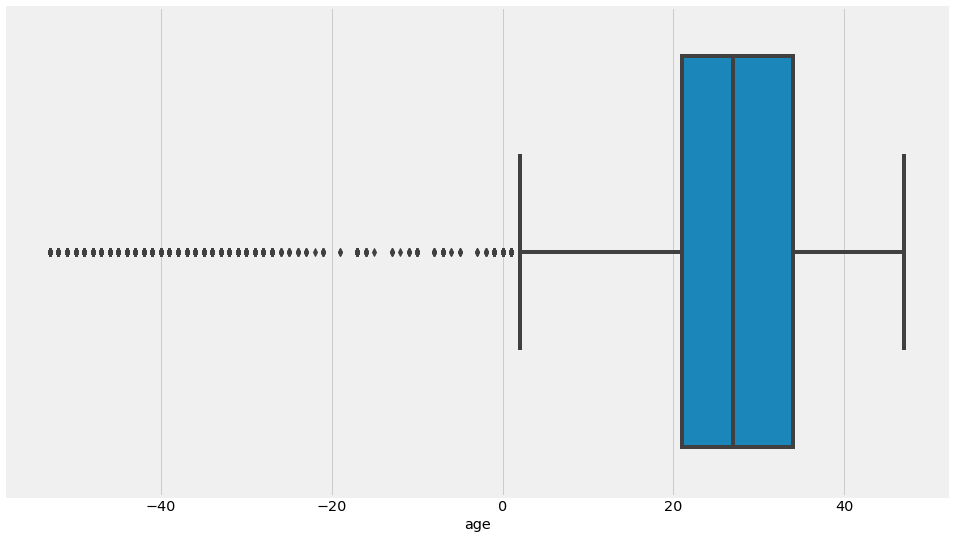

In [41]:
sns.boxplot(df.age)

There are many outliers and fake birthdates, so we will use median age instead of mean age.

### Total sales by cohort

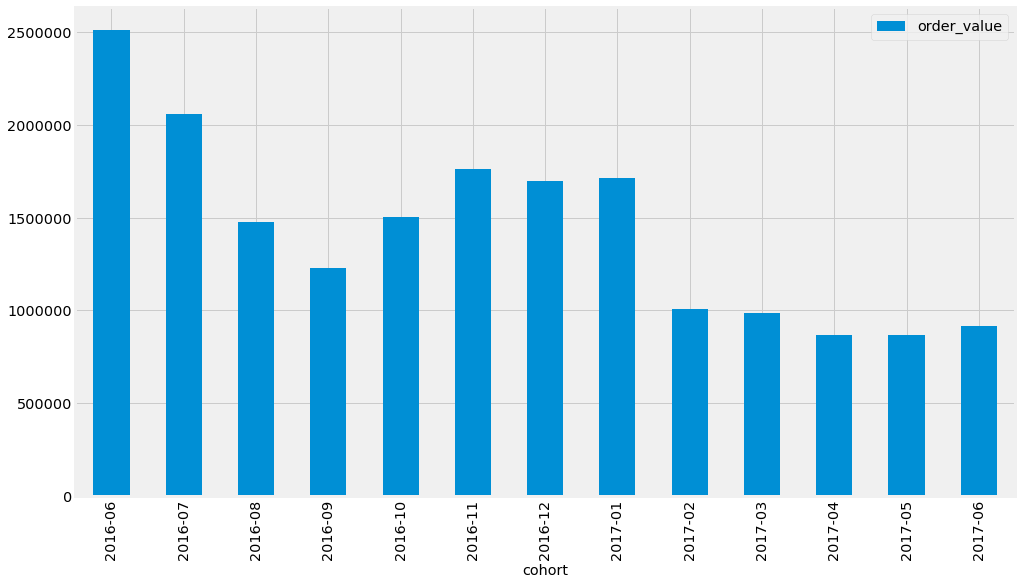

In [42]:
df.groupby('cohort').agg({'order_value': 'sum'}).plot(kind='bar')

### Average Order Value by cohort

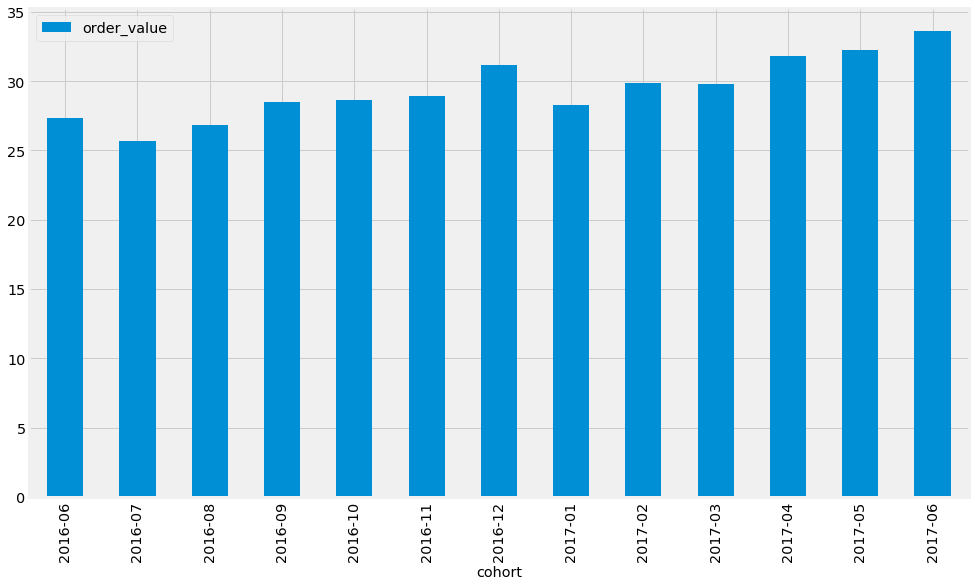

In [43]:
df.groupby('cohort').agg({'order_value': 'mean'}).plot(kind='bar')

### Number of customers in each cohort

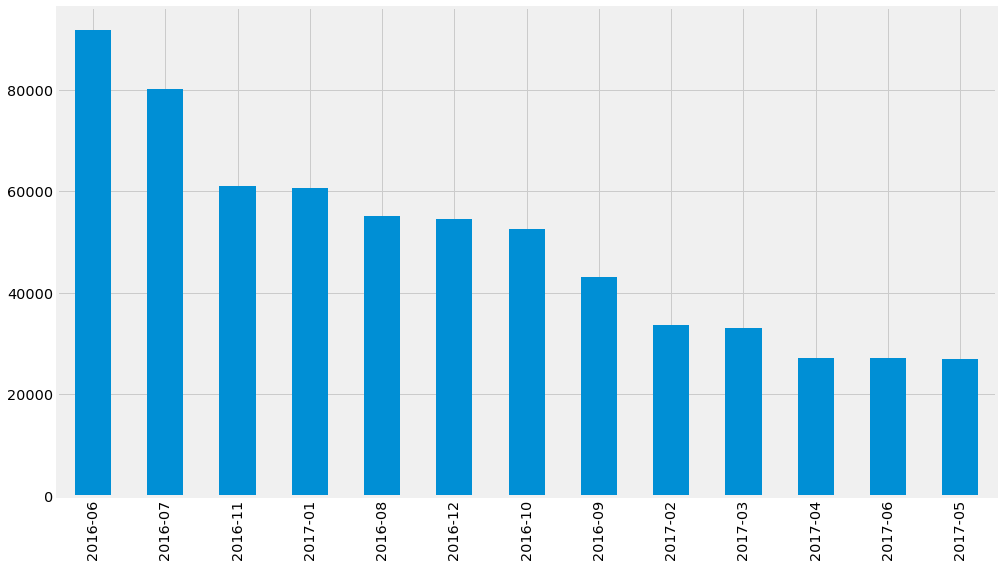

In [44]:
df.cohort.value_counts().plot(kind='bar')

### Gender make-up of customers

In [45]:
# count number of male and female customers
df.groupby('gender').zuid.count()

gender
female    518053
male      127318
Name: zuid, dtype: int64

In [46]:
females = df.groupby('gender').zuid.count()[0]
males = df.groupby('gender').zuid.count()[1]
total = df.groupby('gender').zuid.count().sum()

In [47]:
print('percentage of female customers:', "{:.2f}%".format(females/total*100))
print('percentage of male customers:', "{:.2f}%".format(males/total*100))

percentage of female customers: 80.27%
percentage of male customers: 19.73%


In [48]:
# order value by gender
df.groupby('gender').mean()

,order_value,order_hour,order_month,order_day,age
gender,,,,,
female,28.200806,14.513810,6.341735,2.941869,24.500969
male,31.029860,14.291255,6.618122,2.987535,23.903723


No significant difference in average order value by gender.

### Average order value

In [49]:
# calculate total order value for each order
df_order_value = df.groupby('order_nr').agg({'order_value': 'sum'})

In [50]:
df_order_value.describe()

,order_value
count,267262.000000
mean,69.577323
std,62.471352
min,-445.780000
25%,32.620000
50%,53.080000
75%,88.640000
max,2955.530000


In [51]:
# median order value
df_order_value.median()

order_value    53.08
dtype: float64

### How many orders were made with vouchers?

In [52]:
# for each order, count number of voucher codes used
df_voucher_code = df.groupby('order_nr').agg({'voucher_code': 'count'}).sort_values('voucher_code')

In [53]:
df_voucher_code

,voucher_code
order_nr,
201111135,0
206752655,0
206752675,0
206752725,0
206752737,0
...,...
204345491,60
203639215,60
207875941,61


In [54]:
# find number of orders that had voucher code applied
orders_with_vouchers = len(df_voucher_code[df_voucher_code.voucher_code > 0])
orders_with_vouchers

74656

In [55]:
# percentage of orders with voucher code applied
orders_with_vouchers/len(df_voucher_code)*100

27.93363815282382

### Number of voucher codes

In [56]:
# total number of voucher codes (seen from length of column)
df.voucher_code.value_counts()

ZLAPP15          16764
GRABRWF20         5927
UOBZ520           4733
RED20             4275
BFCM18            4261
                 ...  
NL5URWN              1
NL10LQF              1
NLYC82O              1
SHOPCITIE2AY3        1
IVAEE2AJJ            1
Name: voucher_code, Length: 13403, dtype: int64

### Average number of orders per voucher

In [57]:
print('on average, the number of orders generated per campaign is:')

# orders with vouchers applied / number of voucher codes
74656 / 13403

on average, the number of orders generated per campaign is:


5.570096247108856

### Top 20 vouchers

In [58]:
df.voucher_code.value_counts().head(20)

ZLAPP15        16764
GRABRWF20       5927
UOBZ520         4733
RED20           4275
BFCM18          4261
BRANDNEW        3586
SHOPDBS20       3552
SALE18          3441
UOBSHOP20       3428
UOBGSS20        2759
BESTEVER        2277
FEVERPITCH      2182
MERRYCITI20     2149
SHOP11NG        2108
PERFECT10       2027
ZBAPQZJ0        1899
MERRYCITI18     1886
FEBTASY         1820
SUMMER17        1701
JULYJOY         1532
Name: voucher_code, dtype: int64

### Worst 20 vouchers

In [59]:
df.voucher_code.value_counts().tail(20)

NLX650O          1
NLYCOFN          1
NL6PNCH          1
SHOPCITIE2GHE    1
NL15CSSH96H      1
NL537PV          1
NLPDIVO          1
NL16216          1
NL09TRB          1
NL56YCM          1
NL6973T          1
NLYY1QG          1
NL56Q8I          1
NLTL9HK          1
FEBTASY94T01     1
NL5URWN          1
NL10LQF          1
NLYC82O          1
SHOPCITIE2AY3    1
IVAEE2AJJ        1
Name: voucher_code, dtype: int64

### Which was the best month for sales?

We have data for both June 16 and June 17 sales, so let's keep the June 17 sales for analysis since the rest of the months only have sales data for one year.

In [60]:
# Filter out Jun 16 and use Jun 17 sales for month of June sales.
df_after_jun16 = df[df['order_year_mth'] != '2016-06']

In [61]:
df_after_jun16 

,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_created_at,order_status,order_time,order_hour,order_year_mth,order_month,order_day,age
1,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,27.10,apparel,Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
2,2.13795E+14,male,NaT,2016-07,207816617,mobile,NaN,23.03,apparel,T-Shirts,2016-07-22 13:06:00,net,13:06:00,13,22/7/16,7,4,NaN
3,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
4,2.13795E+14,male,NaT,2016-07,508943717,NaN,NaN,14.02,apparel,Shorts,2016-07-30 11:07:00,net,11:07:00,11,30/7/16,7,5,NaN
5,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929469,2.14674E+14,male,1981-05-05,2017-03,209837635,mobile,5INMARCH,8.05,apparel,Tops,2017-02-03 17:02:00,net,17:02:00,17,2/3/17,2,4,36.0
929470,2.14674E+14,male,1981-05-05,2017-03,209837635,mobile,5INMARCH,8.05,apparel,Tops,2017-02-03 17:02:00,net,17:02:00,17,2/3/17,2,4,36.0
929474,2.14674E+14,male,1981-05-05,2017-03,209837635,mobile,5INMARCH,12.93,apparel,Tops,2017-02-03 17:02:00,net,17:02:00,17,2/3/17,2,4,36.0
929475,2.14674E+14,male,1981-05-05,2017-03,209837635,mobile,5INMARCH,10.49,apparel,Tops,2017-02-03 17:02:00,net,17:02:00,17,2/3/17,2,4,36.0


In [62]:
df_monthly = df_after_jun16.groupby('order_month', as_index=False).agg({'order_value':'sum'})
df_monthly

,order_month,order_value
0,1,1849293.74
1,2,1312807.50
2,3,1509970.31
3,4,1407255.10
4,5,1596926.82
5,6,2564238.56
6,7,1301912.72
7,8,1174114.75
8,9,1091742.78
9,10,1260014.11


#### Currency formatter

In [63]:
# truncate large currency values
def currency(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e6:
        c = '${:1.1f}M'.format(x*1e-6)
    else:
        c = '${:1.0f}K'.format(x*1e-3)
    return c

curr_formatter = FuncFormatter(currency)

#### Large number formatter

In [64]:
# truncate large numbers
def number(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e6:
        c = '{:1.1f}M'.format(x*1e-6)
    else:
        c = '{:1.0f}K'.format(x*1e-3)
    return c

num_formatter = FuncFormatter(number)

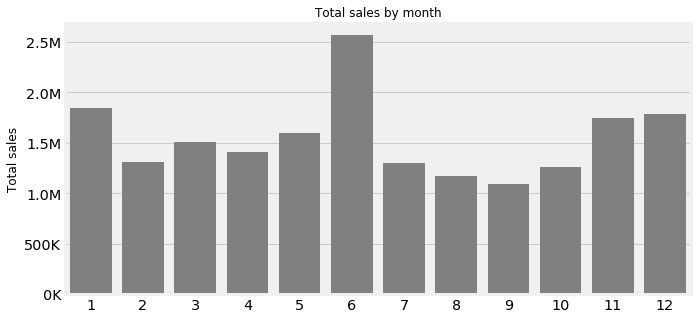

In [65]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_monthly, 
            x='order_month', 
            y='order_value',
            color='grey')
plt.xlabel(None)
plt.ylabel('Total sales', size='large')
plt.title('Total sales by month', size='large')
ax.yaxis.set_major_formatter(num_formatter)

### Try a rolling average for more granular trend

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646680 entries, 1 to 929476
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zuid              646680 non-null  object        
 1   gender            645371 non-null  object        
 2   birthday          397118 non-null  datetime64[ns]
 3   cohort            646680 non-null  object        
 4   order_nr          646680 non-null  object        
 5   environment       631877 non-null  object        
 6   voucher_code      238108 non-null  object        
 7   order_value       646680 non-null  float64       
 8   category          628265 non-null  object        
 9   sub_category      646574 non-null  object        
 10  order_created_at  646680 non-null  datetime64[ns]
 11  order_status      646680 non-null  object        
 12  order_time        646680 non-null  object        
 13  order_hour        646680 non-null  int64         
 14  orde

In [67]:
df_dateindex = df.set_index('order_created_at', drop=True)
df_dateindex

,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_status,order_time,order_hour,order_year_mth,order_month,order_day,age
order_created_at,,,,,,,,,,,,,,,,,
2016-02-08 00:52:00,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,27.10,apparel,Shirts,net,00:52:00,0,2/8/16,2,0,NaN
2016-07-22 13:06:00,2.13795E+14,male,NaT,2016-07,207816617,mobile,NaN,23.03,apparel,T-Shirts,net,13:06:00,13,22/7/16,7,4,NaN
2016-02-08 00:52:00,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,net,00:52:00,0,2/8/16,2,0,NaN
2016-07-30 11:07:00,2.13795E+14,male,NaT,2016-07,508943717,NaN,NaN,14.02,apparel,Shorts,net,11:07:00,11,30/7/16,7,5,NaN
2016-02-08 00:52:00,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,net,00:52:00,0,2/8/16,2,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-03 17:02:00,2.14674E+14,male,1981-05-05,2017-03,209837635,mobile,5INMARCH,8.05,apparel,Tops,net,17:02:00,17,2/3/17,2,4,36.0
2017-02-03 17:02:00,2.14674E+14,male,1981-05-05,2017-03,209837635,mobile,5INMARCH,8.05,apparel,Tops,net,17:02:00,17,2/3/17,2,4,36.0
2017-02-03 17:02:00,2.14674E+14,male,1981-05-05,2017-03,209837635,mobile,5INMARCH,12.93,apparel,Tops,net,17:02:00,17,2/3/17,2,4,36.0


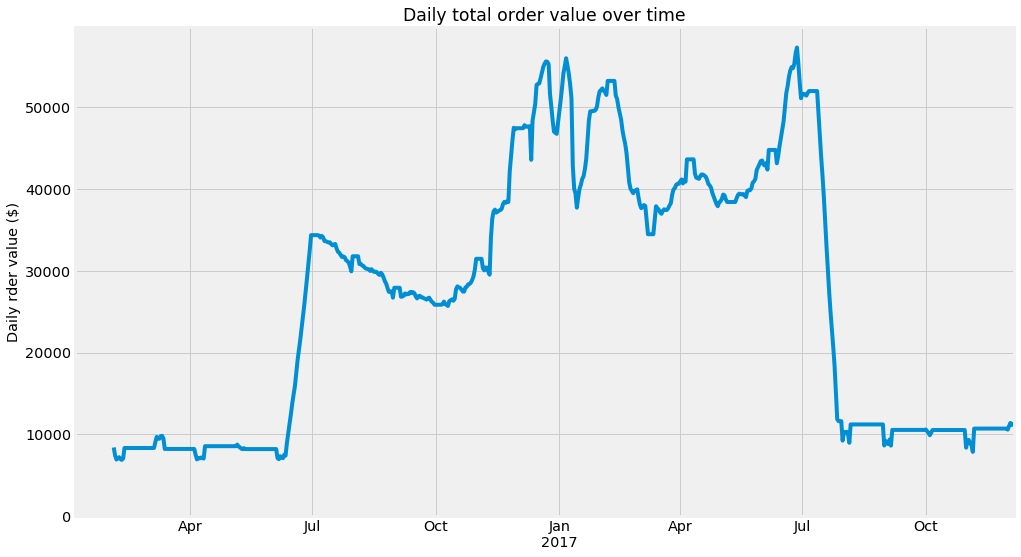

In [68]:
ax = df_dateindex.resample('D').sum().rolling(30).mean()['order_value'].plot()
plt.xlabel(None)
plt.ylabel('Daily rder value ($)')
plt.title('Daily total order value over time')
ax.set_ylim(0, None)
plt.savefig('rolling_aov.png', transparent=True, dpi=300);

### Which day of the week receives the most orders?

In [69]:
df_dayweek = df.groupby('order_day', as_index=False).order_nr.count().sort_values('order_day')
df_dayweek.T

,0,1,2,3,4,5,6
order_day,0,1,2,3,4,5,6
order_nr,101385,95225,88185,88868,90630,86808,95579


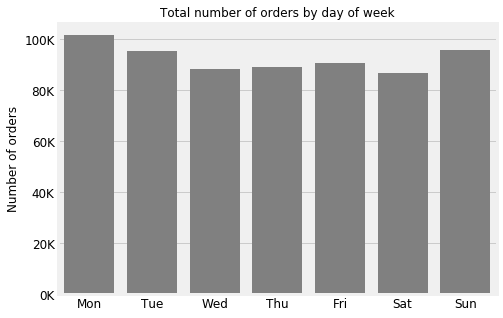

In [70]:
plt.figure(figsize=(7,5))
ax = sns.barplot(data=df_dayweek, 
            x='order_day', 
            y='order_nr',
            color='grey')
plt.xlabel(None)
plt.ylabel('Number of orders', size='large')
plt.title('Total number of orders by day of week', size='large')
bars = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
y_pos = np.arange(len(bars))
plt.xticks(y_pos, bars, size='large')
plt.yticks(size='large')
ax.yaxis.set_major_formatter(num_formatter)
plt.savefig('order_by_weekday.png', transparent=True, dpi=300, pad_inches=0.1);

### Orders by hour of day

In [71]:
# get the number of unique orders in each hour
df_hour = df.groupby('order_hour').agg({'order_nr': pd.Series.nunique}).reset_index()
df_hour.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_nr,14681,8023,4174,2238,1389,1432,1966,3426,5832,9159,...,14879,14983,15161,14119,12724,11604,14869,20009,22342,21871


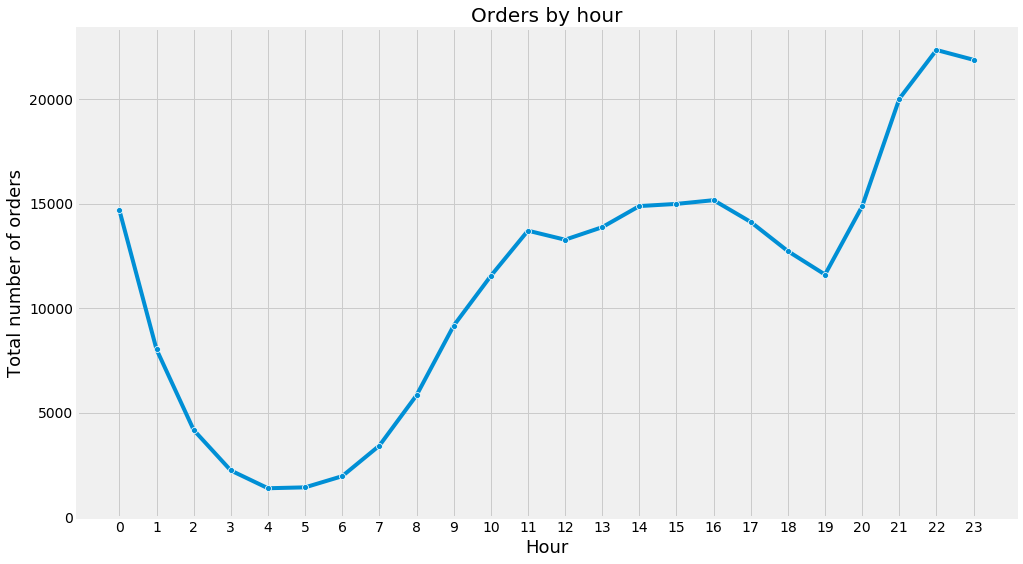

In [72]:
ax = sns.lineplot(data=df_hour, x='order_hour', y='order_nr', marker='o')
x = df_hour.order_hour   # show all the xticks in graph
plt.xticks(x, size=14)
plt.ylim(0, None)
plt.yticks(size=14)
plt.xlabel('Hour', size=18)
plt.ylabel('Total number of orders', size=18)
plt.title('Orders by hour', size=20);

### Which environment did the most number of sales come from?

In [73]:
# find number of unique orders made in each environment
df_env = df.groupby('environment', as_index=False).agg({'order_nr': pd.Series.nunique})

In [74]:
df_env

,environment,order_nr
0,desktop,83737
1,mobile,165210
2,tablet,6174


In [75]:
df_env.columns= ['environment', 'total orders']

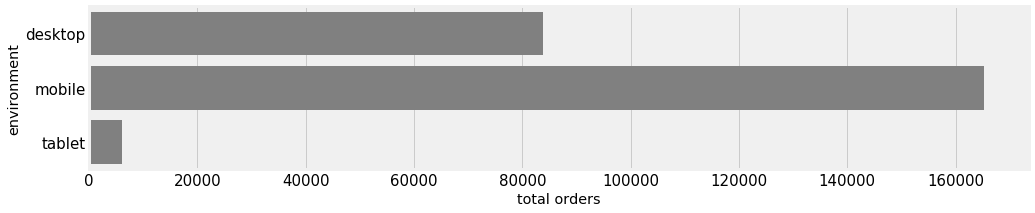

In [76]:
plt.figure(figsize=(15, 3))
sns.barplot(data=df_env, x='total orders', y='environment', color='grey')
plt.yticks(size=15)
plt.xticks(size=15);

Orders made on mobile app are almost twice of tablet and desktop orders combined.

### Which category is most popular?

In [77]:
df_cat = df.groupby('category', as_index=False).agg({'order_value': 'sum'}).sort_values('order_value', ascending=False)

In [78]:
df_cat

,category,order_value
1,apparel,8.784352e+06
0,accessories,2.974620e+06
3,footwear,2.957283e+06
5,sports,1.507744e+06
6,traditional,1.486579e+06
2,beauty,4.174349e+05
4,kids,3.064810e+03


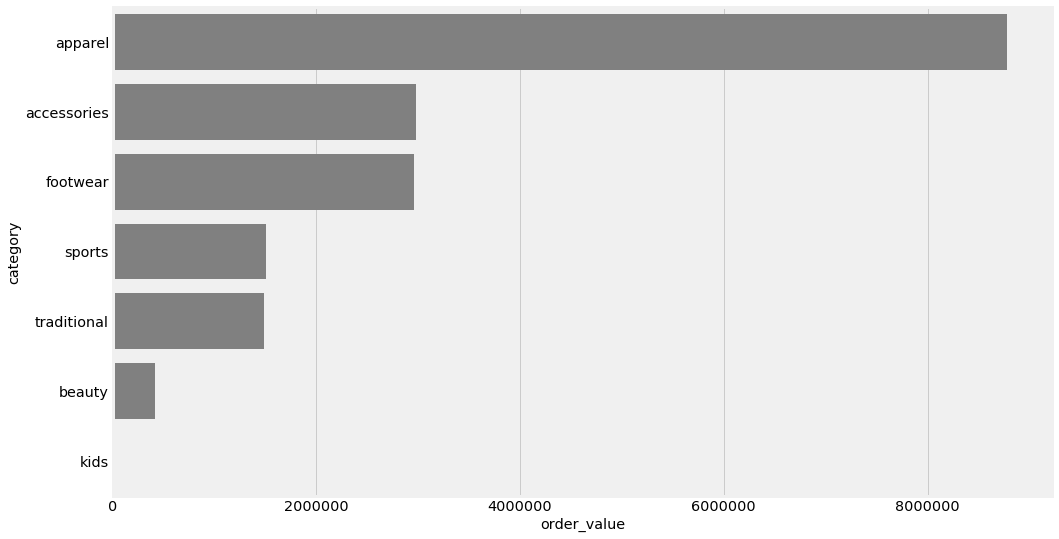

In [79]:
sns.barplot(data=df_cat, 
            x='order_value', 
            y='category', 
            color='grey', 
            saturation=.5)


### Which sub-category is most popular?

In [80]:
df_subcat = df.groupby('sub_category', as_index=False).agg({'order_value': 'sum'}).sort_values('order_value', ascending=False)

In [81]:
df_subcat = df_subcat.head(20)
df_subcat

,sub_category,order_value
12,Dresses,3.419438e+06
76,Tops,1.321077e+06
80,Traditional Dresses,9.233018e+05
0,Backpacks,7.275165e+05
86,Watches,6.962357e+05
54,Sneakers,6.396705e+05
73,T-Shirts,5.996371e+05
22,Heels,5.820643e+05
45,Sandals & Flip Flops,5.485055e+05
61,Sports Lifestyle Shoes,5.168263e+05


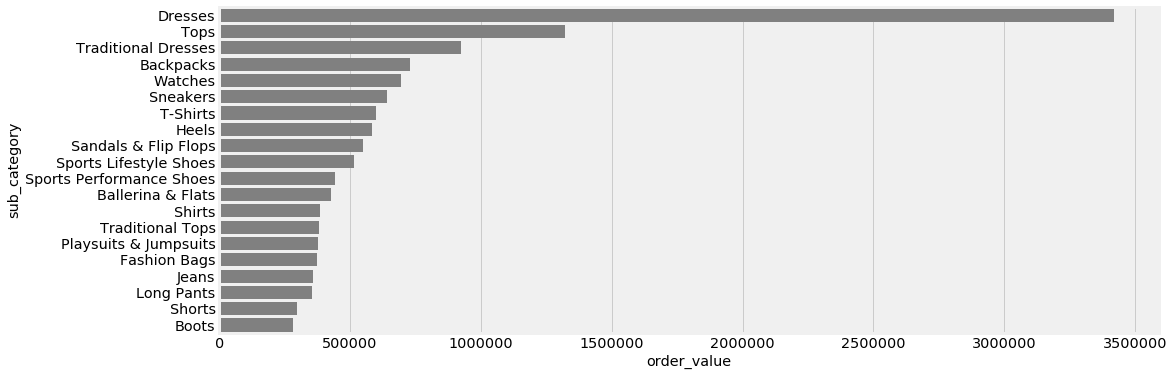

In [82]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_subcat, 
            x='order_value', 
            y='sub_category', 
            color='grey', 
            saturation=.5);

# RFM analysis

### Formulas

- Recency: **number of days** between present date and date of last purchase for each customer.<br>
- Frequency: **number of orders** for each customer.<br>
- Monetary: **total sum of order value** for each customer.

There are three basic steps to RFM analysis:
1. Sort all customers in ascending order based on Recency, Frequency and Monetary Value.
2. Split customers into 4 or 5 for each factor.
3. Combine factors to group customers into RFM segments for targeted marketing.

In [84]:
# Timeframe of the data
print('We will do our RFM analysis from {} to {}.'.format(df['order_created_at'].min(),
                                    df['order_created_at'].max()))

We will do our RFM analysis from 2016-01-06 00:00:00 to 2017-12-06 23:57:00.


## Find the last purchase date of each customer

In [85]:
df.head()

,zuid,gender,birthday,cohort,order_nr,environment,voucher_code,order_value,category,sub_category,order_created_at,order_status,order_time,order_hour,order_year_mth,order_month,order_day,age
1,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,27.10,apparel,Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
2,2.13795E+14,male,NaT,2016-07,207816617,mobile,NaN,23.03,apparel,T-Shirts,2016-07-22 13:06:00,net,13:06:00,13,22/7/16,7,4,NaN
3,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN
4,2.13795E+14,male,NaT,2016-07,508943717,NaN,NaN,14.02,apparel,Shorts,2016-07-30 11:07:00,net,11:07:00,11,30/7/16,7,5,NaN
5,2.13795E+14,male,NaT,2016-07,205926117,mobile,NaN,13.93,apparel,T-Shirts,2016-02-08 00:52:00,net,00:52:00,0,2/8/16,2,0,NaN


In [86]:
# Group by customer ID and retrieve last date of purchase
recency_df = df.groupby(by='zuid', as_index=False)['order_created_at'].max()
recency_df.columns = ['zuid','last_purchase_date']
recency_df.head()

,zuid,last_purchase_date
0,2.13795E+14,2017-12-06 23:55:00
1,2.13796E+14,2017-11-01 21:43:00
2,2.13797E+14,2017-12-03 17:26:00
3,2.13798E+14,2017-06-19 14:50:00
4,2.13799E+14,2017-12-04 19:17:00


To simulate an analysis in real time, we can set the CURRENT date at one day after the last purchase.<br> 
This date will be used as a reference to calculate the Recency score.

In [87]:
CURRENT = df['order_created_at'].max() + timedelta(days=1)
CURRENT

Timestamp('2017-12-07 23:57:00')

In [88]:
rfm = df.groupby('zuid').agg({'order_created_at': lambda date: (CURRENT - date.max()).days, # days since last order
                                        'order_nr': lambda num: len(num), # number of orders made
                                        'order_value': lambda value: value.sum()}) # sum of all order values

In [89]:
rfm.columns = ['recency', 'frequency', 'monetary']

In [90]:
rfm

,recency,frequency,monetary
zuid,,,
2.13795E+14,1,27056,805751.03
2.13796E+14,36,23,336.31
2.13797E+14,4,75,1577.63
2.13798E+14,171,50,2621.52
2.13799E+14,3,40,1064.96
...,...,...,...
2.14985E+14,162,524,17832.57
2.14986E+14,163,68,2347.60
2.1498E+14,163,595,22613.19


## Histogram based on Frequency

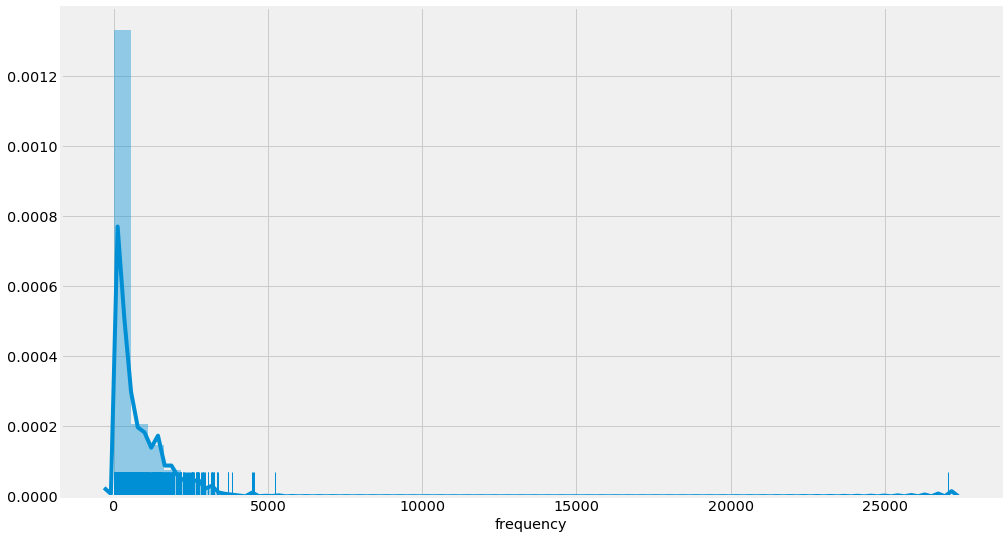

In [91]:
sns.distplot(rfm.frequency, rug=True);

### Inspect distribution of frequency

In [92]:
freq_list = []
cust_count_list = []
cust_count_pct_list = []

for i in range(1,6):
    cust_count = rfm[rfm['frequency'] == i]['frequency'].count()
    cust_count_pct = cust_count/len(rfm)
    
    freq_list.append(i)
    cust_count_list.append(cust_count)
    cust_count_pct_list.append(cust_count_pct)
    
    print(cust_count, 'customers purchased', i, 'time(s)')
    print("{:.2f}%".format(cust_count_pct*100), 'customers purchased', i, 'time(s)\n')

0 customers purchased 1 time(s)
0.00% customers purchased 1 time(s)

0 customers purchased 2 time(s)
0.00% customers purchased 2 time(s)

0 customers purchased 3 time(s)
0.00% customers purchased 3 time(s)

0 customers purchased 4 time(s)
0.00% customers purchased 4 time(s)

0 customers purchased 5 time(s)
0.00% customers purchased 5 time(s)



In [93]:
df_freq = pd.DataFrame(list(zip(freq_list, cust_count_list, cust_count_pct_list)), 
               columns =['purchase_count', 'cust_count', 'cust_pct']) 
df_freq

,purchase_count,cust_count,cust_pct
0,1,0,0.0
1,2,0,0.0
2,3,0,0.0
3,4,0,0.0
4,5,0,0.0


In [94]:
df_freq.cust_pct.cumsum()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: cust_pct, dtype: float64

## Histogram based on Recency

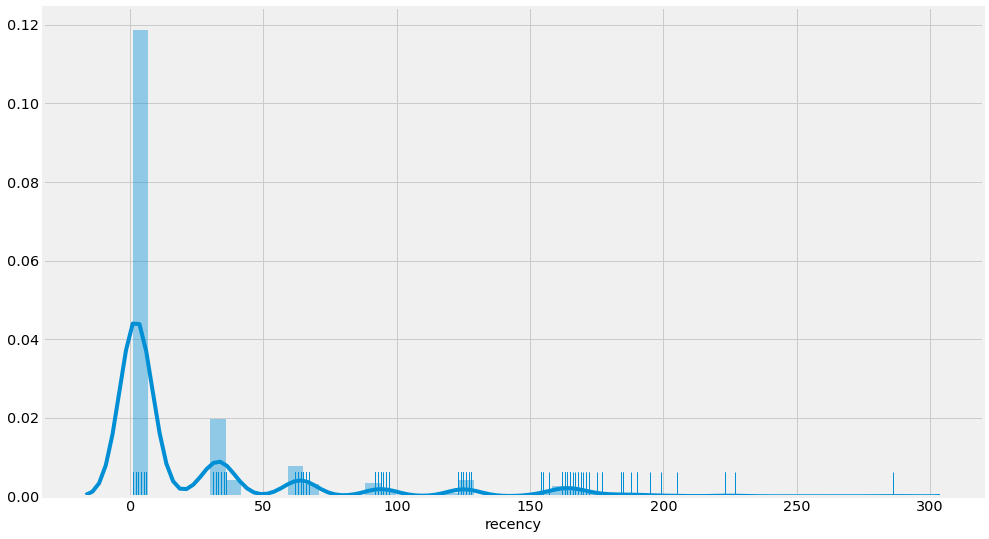

In [95]:
sns.distplot(rfm.recency, rug=True);

In [96]:
rfm.recency.quantile([.2, .4, .6, .8]).to_list()

[1.0, 2.0, 5.0, 35.0]

## Histogram based on Monetary value

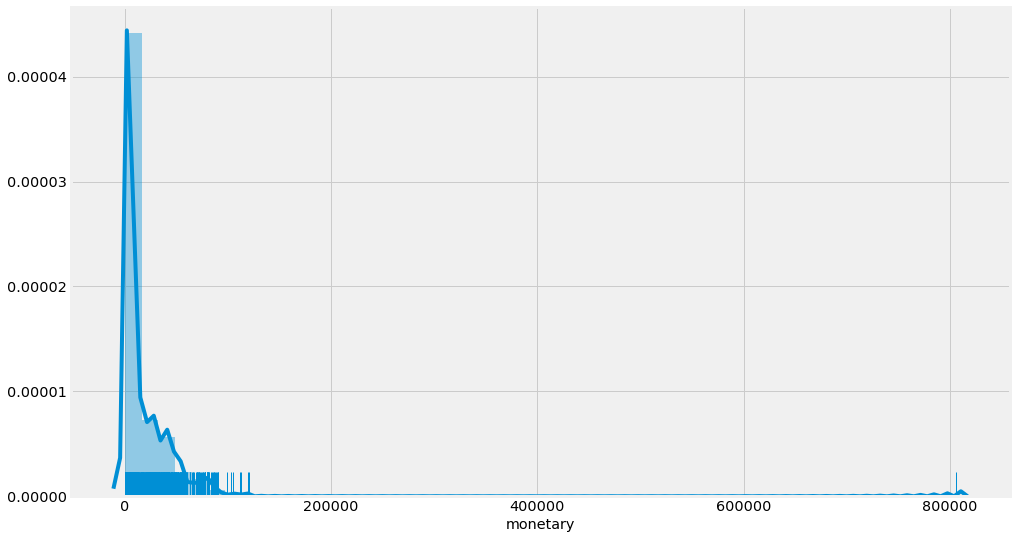

In [97]:
sns.distplot(rfm.monetary, rug=True);

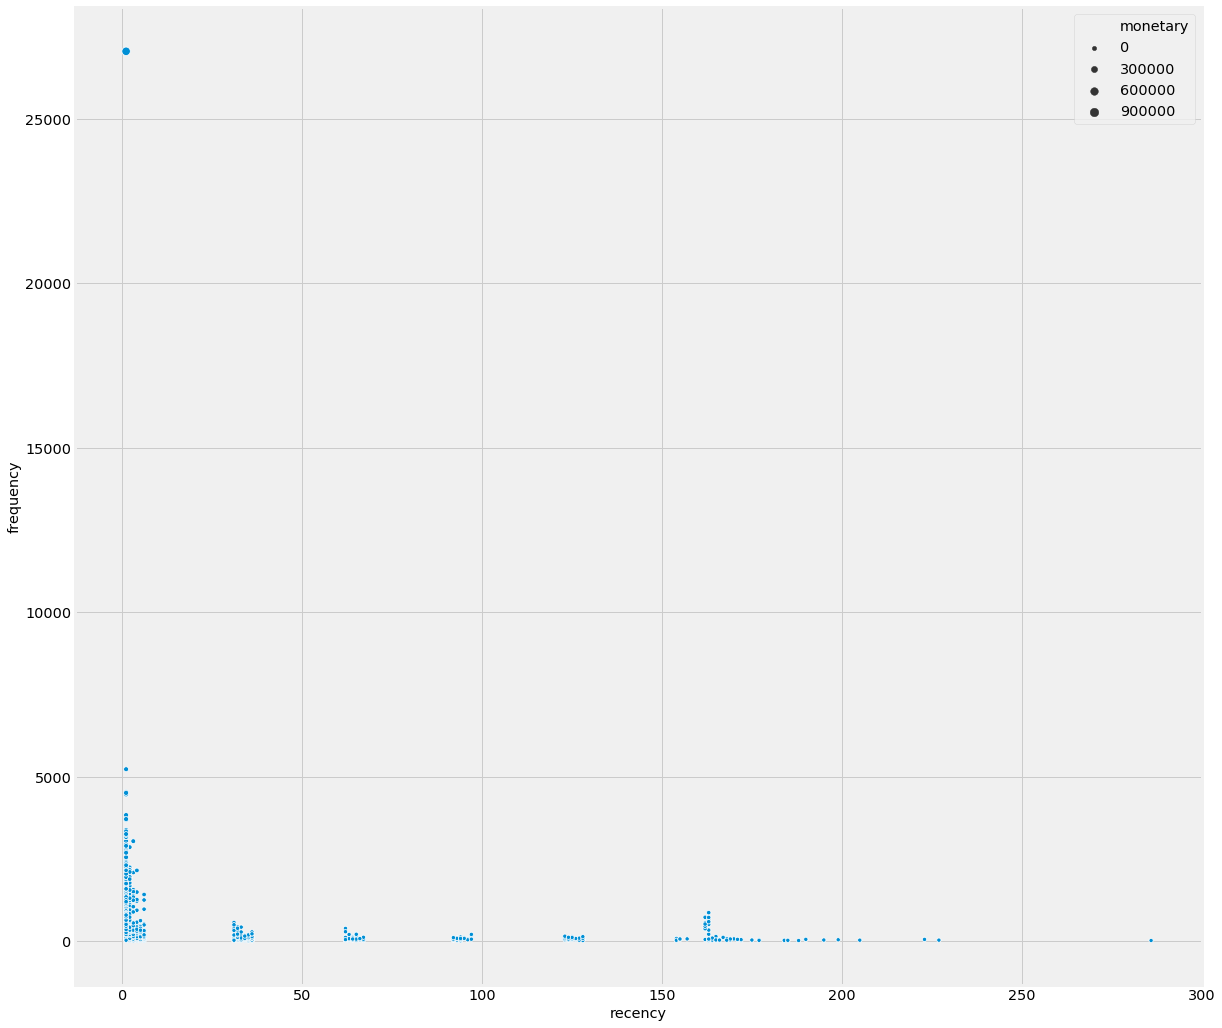

In [98]:
plt.figure(figsize=(18, 18))
sns.scatterplot(data=rfm, 
                x='recency', 
                y='frequency',
                size='monetary')

## Computing Quantile of RFM values

    
The common practice is to divide the customers into 4 or 5 bins. We will go with 5 bins here for more granular analysis and also because the time frame is slightly longer than the conventional one-year timeframe for RFM analysis.

In [99]:
quintiles = rfm.quantile([.2, .4, .6, .8]).to_dict()
pd.DataFrame(quintiles)

,recency,frequency,monetary
0.2,1.0,74.0,2126.512
0.4,2.0,118.4,3422.632
0.6,5.0,245.2,6811.280
0.8,35.0,905.0,27733.912


In [100]:
# For Recency, the label is inverse that of Frequency and Monetary.
# This is because a smaller value for Recency is better while larger value for Frequency and Monetary are better.

def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, column):
    if x <= quintiles[column][.2]:
        return 1
    elif x <= quintiles[column][.4]:
        return 2
    elif x <= quintiles[column][.6]:
        return 3
    elif x <= quintiles[column][.8]:
        return 4
    else:
        return 5

In [101]:
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['M'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

In [102]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1192 entries, 2.13795E+14 to 2.14E+14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    1192 non-null   int64  
 1   frequency  1192 non-null   int64  
 2   monetary   1192 non-null   float64
 3   R          1192 non-null   int64  
 4   F          1192 non-null   int64  
 5   M          1192 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 105.2+ KB


In [103]:
rfm['RFM_score'] = rfm['R'].apply(str) + rfm['F'].apply(str) + rfm['M'].apply(str)

In [104]:
rfm # 5 is the best score

,recency,frequency,monetary,R,F,M,RFM_score
zuid,,,,,,,
2.13795E+14,1,27056,805751.03,5,5,5,555
2.13796E+14,36,23,336.31,1,1,1,111
2.13797E+14,4,75,1577.63,3,2,1,321
2.13798E+14,171,50,2621.52,1,1,2,112
2.13799E+14,3,40,1064.96,3,1,1,311
...,...,...,...,...,...,...,...
2.14985E+14,162,524,17832.57,1,4,4,144
2.14986E+14,163,68,2347.60,1,1,2,112
2.1498E+14,163,595,22613.19,1,4,4,144


### Divide customers into segments based on Recency and Frequency

In [105]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'Churn risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About to sleep',
    r'33': 'Require attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Recent customer',
    r'51': 'New customer',
    r'[4-5][2-3]': 'Potential loyalists',
    r'5[4-5]': 'Champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,recency,frequency,monetary,R,F,M,RFM_score,Segment
zuid,,,,,,,,
2.13795E+14,1,27056,805751.03,5,5,5,555,Champions
2.13796E+14,36,23,336.31,1,1,1,111,Hibernating
2.13797E+14,4,75,1577.63,3,2,1,321,About to sleep
2.13798E+14,171,50,2621.52,1,1,2,112,Hibernating
2.13799E+14,3,40,1064.96,3,1,1,311,About to sleep


In [106]:
pd.DataFrame(rfm.Segment.value_counts())

,Segment
Champions,325
Hibernating,293
Churn risk,133
Potential loyalists,120
Loyal customers,114
About to sleep,91
Require attention,72
New customer,33
Recent customer,8
Cannot lose them,3
